In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
import scipy.signal as signal

In [24]:
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [25]:
def adaptive_normalization(signal, window_size=256):
    normalized = np.zeros_like(signal)

    for i in range(len(signal)):
        start = max(0, i - window_size // 2)
        end = min(len(signal), i + window_size // 2)

        local_mean = np.mean(signal[start:end])
        local_std = np.std(signal[start:end])

        normalized[i] = (signal[i] - local_mean) / local_std
    return normalized

In [26]:
ppg_sr = 256

In [27]:
data = pd.read_csv('/home/ilya/Documents/stress-level-by-PPG/dataframe/test_physical_activity_2.csv')

sec_with = 60
num_sec = 300

ppg_md = data["afe_LED1ABSVAL"][sec_with * ppg_sr: (sec_with + num_sec) * ppg_sr]
filt_ppg = bandpass_filter(ppg_md, 1, 5, ppg_sr)
adapt_ppg = adaptive_normalization(filt_ppg, 1024)


In [28]:
# signals, info = nk.ppg_process(adapt_ppg, sampling_rate=ppg_sr)

# rpeaks = info["PPG_Peaks"]
# rr_intervals = np.diff(rpeaks) / ppg_sr * 1000

# fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=False)

# # 1. PPG-сигнал с пиками
# axs[0].plot(signals["PPG_Clean"], label="PPG (очищенный)", color='blue')
# axs[0].plot(rpeaks, signals["PPG_Clean"][rpeaks], 'ro', label="Пики")
# axs[0].set_title("PPG-сигнал с помеченными пиками")
# axs[0].set_ylabel("Амплитуда")
# axs[0].legend()
# axs[0].grid(True)
# axs[0].set_ylim(-3,3)

# # 2. RR-интервалы во времени
# axs[1].plot(rr_intervals, marker='o', color='green')
# axs[1].set_title("RR-интервалы (в миллисекундах)")
# axs[1].set_ylabel("Интервал RR (мс)")
# axs[1].grid(True)
# axs[1].set_ylim(300,1500)

# # 3. Гистограмма RR-интервалов
# axs[2].hist(rr_intervals, bins=30, color='purple', edgecolor='black', alpha=0.7)
# axs[2].set_title("Распределение")
# axs[2].set_ylabel("Частота")
# axs[2].grid(True)
# axs[2].set_xlim(200,1500)
# axs[2].set_ylim(0,150)

# plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working with braslet/test_physical_activity_2.png', dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.  ]


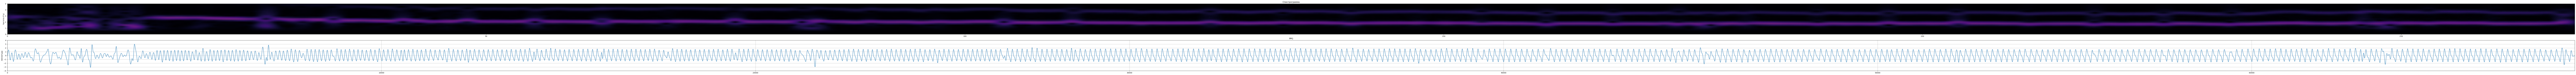

In [29]:
frequencies, times, Zxx = signal.stft(
    adapt_ppg, 
    fs=256, 
    window='hann', 
    nperseg=1024,
    noverlap=1000
)

spectrogram = np.abs(Zxx)
# print(frequencies)

# Маска для целевой частоты
min_fr = 0
max_fr = 5
freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)
print(frequencies[freq_mask])

# Амплитуда в целевой полосе
amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

wight = len(adapt_ppg) / 256
plt.figure(figsize=(wight, 7))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies[freq_mask], spectrogram[freq_mask, : ], shading='gouraud', cmap='magma', vmin = 0, vmax=2)
# plt.colorbar(label='Амплитуда (дБ)')
plt.ylabel('Частота (Гц)')
plt.title('Спектрограмма')

plt.subplot(2, 1, 2)
plt.plot(adapt_ppg)
plt.ylabel('Амплитуда')
plt.title(f'PPG')
plt.grid(True)
plt.margins(x=0)
plt.ylim(-4, 4)

plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/spgrm_ppg_st.png', dpi=300, bbox_inches='tight')

plt.show()

plt.close()